# RNA-Seq Data Analysis Pipeline Tutorial

RNA-seq tutorial pipeline from fastq files to differential expression.

## Basic Metadata

RNA-Seq data from 19 subjects with 3 replicates each, P8 samples are from Marginal Zone B cells and P9 samples are from follicular B cells, from both wild type and IgA Knockout mice. <br>
Conditions that will be analyzed for the identification of differential expression genes (DEGs) are:<br>
1.WT-P8,WT-P9 vs IgaKO-P8, IgaKO-P9<br>
2.WT-P8 vs IgaKO-P8<br>
3.WT-P9 vs Iga-P9<br>

______________________________________________________________________________________________

## Pipeline Overview

1) Generate genome Index file.<br>
2) Read Alignment (STAR)<br>
3) Assign reads to genes (featureCounts)<br>
4) Compute CPM and RPKM (EdgeR Bioconductor package)<br>
5) Filter non expressed genes<br>
6) Filter lowly expressed genes<br>
7) PCA<br>
8) Visualization (Clustergrammer)<br>
9) Identify differentially expressed genes (Characteristic Direction)<br>
10) Subset the expression DataFrame using top 800 genes with largest variance<br>
11) Enrichment Analysis (Enrichr)<br>
12) Characteristic Direction Signature Search (L1000CDS2)<br>

______________________________________________________________________________________________

______________________________________________________________________________________________

After successfull completion of the above steps 1 - 4, you can start to analyze the processed expression matrix of gene expression in Python.

In [189]:
import pandas as pd
import numpy as np

In [190]:
## Assign the four variables: ctrl_ids and cond_ids; 
## ctrl_ids are the control samples; and pert_ids are the treatment samples.
## Make sure that there are at least two samples in each group to be able to perform the characteristic direction.
WTP8_ids = ['11-1163-Wt-P8','21-1165-Wt-P8', '31-1167-Wt-P8', '41-1169-Wt-P8']
WTP9_ids = ['2-1161-Wt-P9', '12-1163-Wt-P9', '22-1165-Wt-P9', '32-1167-Wt-P9', '42-1169-Wt-P9']
IgAKOP8_ids = ['16-1164-IgAKO-P8', '26-1166-IgAKO-P8', '36-1168-IgAKO-P8', '46-1170-IgAKO-P8', '6-1162-IgAKO-P8']
IgAKOP9_ids = ['17-1164-IgAKO-P9','27-1166-IgAKO-P9','37-1168-IgAKO-P9','47-1170-IgAKO-P9','7-1162-IgAKO-P9']

In [191]:
## Check the featureCount_output summary files for the alignment stats.
## This will output the first 10 lines of all summary files from the featureCounts folder
!head ../featureCount_output/*.summary 

head: ../featureCount_output/*.summary: No such file or directory


maayanlab@isabella:~/cdm/featureCount_output$ head /home/maayanlab/cdm/featureCount_output/*.summary
==> /home/maayanlab/cdm/featureCount_output/11-1163-Wt-P8.count.txt.summary <==
Status  /home/maayanlab/cdm/star_output/11-1163-Wt-P8Aligned.sortedByCoord.out.bam
Assigned        21801137
Unassigned_Ambiguity    341618
Unassigned_MultiMapping 31929676
Unassigned_NoFeatures   2803493
Unassigned_Unmapped     0
Unassigned_MappingQuality       0
Unassigned_FragmentLength       0
Unassigned_Chimera      0
Unassigned_Secondary    0

==> /home/maayanlab/cdm/featureCount_output/12-1163-Wt-P9.count.txt.summary <==
Status  /home/maayanlab/cdm/star_output/12-1163-Wt-P9Aligned.sortedByCoord.out.bam
Assigned        23105766
Unassigned_Ambiguity    363702
Unassigned_MultiMapping 26166037
Unassigned_NoFeatures   3506987
Unassigned_Unmapped     0
Unassigned_MappingQuality       0
Unassigned_FragmentLength       0
Unassigned_Chimera      0
Unassigned_Secondary    0

==> /home/maayanlab/cdm/featureCount_output/16-1164-IgAKO-P8.count.txt.summary <==
Status  /home/maayanlab/cdm/star_output/16-1164-IgAKO-P8Aligned.sortedByCoord.out.bam
Assigned        21976115
Unassigned_Ambiguity    331259
Unassigned_MultiMapping 32706166
Unassigned_NoFeatures   3552983
Unassigned_Unmapped     0
Unassigned_MappingQuality       0
Unassigned_FragmentLength       0
Unassigned_Chimera      0
Unassigned_Secondary    0

==> /home/maayanlab/cdm/featureCount_output/17-1164-IgAKO-P9.count.txt.summary <==
Status  /home/maayanlab/cdm/star_output/17-1164-IgAKO-P9Aligned.sortedByCoord.out.bam
Assigned        21334140
Unassigned_Ambiguity    342544
Unassigned_MultiMapping 26502184
Unassigned_NoFeatures   3490312
Unassigned_Unmapped     0
Unassigned_MappingQuality       0
Unassigned_FragmentLength       0
Unassigned_Chimera      0
Unassigned_Secondary    0

==> /home/maayanlab/cdm/featureCount_output/21-1165-Wt-P8.count.txt.summary <==
Status  /home/maayanlab/cdm/star_output/21-1165-Wt-P8Aligned.sortedByCoord.out.bam
Assigned        21766502
Unassigned_Ambiguity    334297
Unassigned_MultiMapping 31851081
Unassigned_NoFeatures   3844298
Unassigned_Unmapped     0
Unassigned_MappingQuality       0
Unassigned_FragmentLength       0
Unassigned_Chimera      0
Unassigned_Secondary    0

==> /home/maayanlab/cdm/featureCount_output/2-1161-Wt-P9.count.txt.summary <==
Status  /home/maayanlab/cdm/star_output/2-1161-Wt-P9Aligned.sortedByCoord.out.bam
Assigned        20206111
Unassigned_Ambiguity    327144
Unassigned_MultiMapping 23157934
Unassigned_NoFeatures   3058347
Unassigned_Unmapped     0
Unassigned_MappingQuality       0
Unassigned_FragmentLength       0
Unassigned_Chimera      0
Unassigned_Secondary    0

==> /home/maayanlab/cdm/featureCount_output/22-1165-Wt-P9.count.txt.summary <==
Status  /home/maayanlab/cdm/star_output/22-1165-Wt-P9Aligned.sortedByCoord.out.bam
Assigned        23400691
Unassigned_Ambiguity    371594
Unassigned_MultiMapping 25620400
Unassigned_NoFeatures   3363646
Unassigned_Unmapped     0
Unassigned_MappingQuality       0
Unassigned_FragmentLength       0
Unassigned_Chimera      0
Unassigned_Secondary    0

==> /home/maayanlab/cdm/featureCount_output/26-1166-IgAKO-P8.count.txt.summary <==
Status  /home/maayanlab/cdm/star_output/26-1166-IgAKO-P8Aligned.sortedByCoord.out.bam
Assigned        22198989
Unassigned_Ambiguity    336579
Unassigned_MultiMapping 31882681
Unassigned_NoFeatures   3186535
Unassigned_Unmapped     0
Unassigned_MappingQuality       0
Unassigned_FragmentLength       0
Unassigned_Chimera      0
Unassigned_Secondary    0

==> /home/maayanlab/cdm/featureCount_output/27-1166-IgAKO-P9.count.txt.summary <==
Status  /home/maayanlab/cdm/star_output/27-1166-IgAKO-P9Aligned.sortedByCoord.out.bam
Assigned        22071305
Unassigned_Ambiguity    348653
Unassigned_MultiMapping 25042770
Unassigned_NoFeatures   3050596
Unassigned_Unmapped     0
Unassigned_MappingQuality       0
Unassigned_FragmentLength       0
Unassigned_Chimera      0
Unassigned_Secondary    0

In [192]:
## Load the expression matrix - edgeR output
expr_df = pd.read_csv('repCpmMatrix_featureCounts.csv')
expr_df = expr_df.set_index(expr_df.columns[0])
expr_df.head()

,11-1163-Wt-P8,12-1163-Wt-P9,16-1164-IgAKO-P8,17-1164-IgAKO-P9,2-1161-Wt-P9,21-1165-Wt-P8,22-1165-Wt-P9,26-1166-IgAKO-P8,27-1166-IgAKO-P9,31-1167-Wt-P8,32-1167-Wt-P9,36-1168-IgAKO-P8,37-1168-IgAKO-P9,41-1169-Wt-P8,42-1169-Wt-P9,46-1170-IgAKO-P8,47-1170-IgAKO-P9,6-1162-IgAKO-P8,7-1162-IgAKO-P9
Unnamed: 0,,,,,,,,,,,,,,,,,,,
Xkr4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rp1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sox17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mrpl15,69.537658,59.638793,61.930874,60.935196,50.875698,61.378719,53.887298,57.029624,57.223621,50.889557,43.34727,47.783774,46.029174,58.289677,53.774432,59.040322,54.512558,64.932263,50.771364
Lypla1,113.526189,113.348330,111.075138,102.792988,112.985621,94.824607,102.219204,97.887341,108.376011,70.153890,78.99866,70.764827,76.036393,112.073642,112.696502,105.297693,121.449761,94.226028,89.829685


In [193]:
print expr_df.shape

(24391, 19)


In [194]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
print (expr_df.shape)

(16971, 19)


In [195]:
## Filter out lowly expressed genes
mask_low_vals = (expr_df > 0.3).sum(axis=1) > 5
expr_df = expr_df.loc[mask_low_vals, :]

print (expr_df.shape)

(11915, 19)


In [196]:
expr_df.to_csv('expr_df', sep=',', na_rep='', float_format=None, columns=None, header=True, index=True, 
               index_label=None, mode='w', encoding=None, compression=None, quoting=None, quotechar='"', 
               line_terminator='\n', tupleize_cols=False, date_format=None, doublequote=True, 
               escapechar=None, decimal='.')

In [197]:
expr_df.head()

,11-1163-Wt-P8,12-1163-Wt-P9,16-1164-IgAKO-P8,17-1164-IgAKO-P9,2-1161-Wt-P9,21-1165-Wt-P8,22-1165-Wt-P9,26-1166-IgAKO-P8,27-1166-IgAKO-P9,31-1167-Wt-P8,32-1167-Wt-P9,36-1168-IgAKO-P8,37-1168-IgAKO-P9,41-1169-Wt-P8,42-1169-Wt-P9,46-1170-IgAKO-P8,47-1170-IgAKO-P9,6-1162-IgAKO-P8,7-1162-IgAKO-P9
Unnamed: 0,,,,,,,,,,,,,,,,,,,
Mrpl15,69.537658,59.638793,61.930874,60.935196,50.875698,61.378719,53.887298,57.029624,57.223621,50.889557,43.347270,47.783774,46.029174,58.289677,53.774432,59.040322,54.512558,64.932263,50.771364
Lypla1,113.526189,113.348330,111.075138,102.792988,112.985621,94.824607,102.219204,97.887341,108.376011,70.153890,78.998660,70.764827,76.036393,112.073642,112.696502,105.297693,121.449761,94.226028,89.829685
Tcea1,45.960906,40.812324,45.230925,39.842243,43.996591,37.948220,42.050040,39.416209,40.641004,30.972196,31.386205,32.509782,31.455532,43.491972,44.260494,44.964154,41.125117,41.128266,38.568422
Atp6v1h,89.261400,76.474418,84.910367,86.059246,76.758957,73.691216,73.373902,83.337129,73.806238,63.483673,61.242506,61.843321,59.199763,73.561667,70.136567,72.768316,78.215663,71.726976,63.642350
Rb1cc1,26.833463,33.108619,24.799652,31.498809,29.990927,22.144119,28.247029,28.379671,35.838388,57.979578,81.873025,67.588584,81.648603,36.899405,51.890029,35.812158,51.394935,23.174023,32.689633


In [198]:
meta_df = pd.read_csv('metadata.txt', sep='\t')
print meta_df.shape
meta_df


(19, 4)


,Unnamed: 0,Condition,Type,Category
0,11-1163-Wt-P8,WT Marginal B cell,WT-11,WTM
1,12-1163-Wt-P9,WT Follicular B cell,WT-12,WTF
2,16-1164-IgAKO-P8,IgA KO Marginal B cell,KO-16,KoM
3,17-1164-IgAKO-P9,IgA KO Follicular B cell,KO-17,KoF
4,2-1161-Wt-P9,WT Follicular B cell,WT-2,WTF
5,21-1165-Wt-P8,WT Marginal B cell,WT-21,WTM
6,22-1165-Wt-P9,WT Follicular B cell,WT-22,WTF
7,26-1166-IgAKO-P8,IgA KO Marginal B cell,KO-26,KoM
8,27-1166-IgAKO-P9,IgA KO Follicular B cell,KO-27,KoF
9,31-1167-Wt-P8,WT Marginal B cell,WT-31,WTM


Now we have everything setup, the first thing to do is to generate PCA plots to observe whether the samples cluster as expected: controls with controls, and treatments with treatments.

In [199]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
# ignore FutureWarning that may pop up when plotting
import warnings
warnings.filterwarnings("ignore")

In [200]:
from IPython.core.display import HTML, display
# to display hyperlink as <a> tag in output cells
def display_link(url):
    raw_html = '<a href="%s" target="_blank">%s</a>' % (url, url)
    return display(HTML(raw_html))

In [201]:
import RNAseq

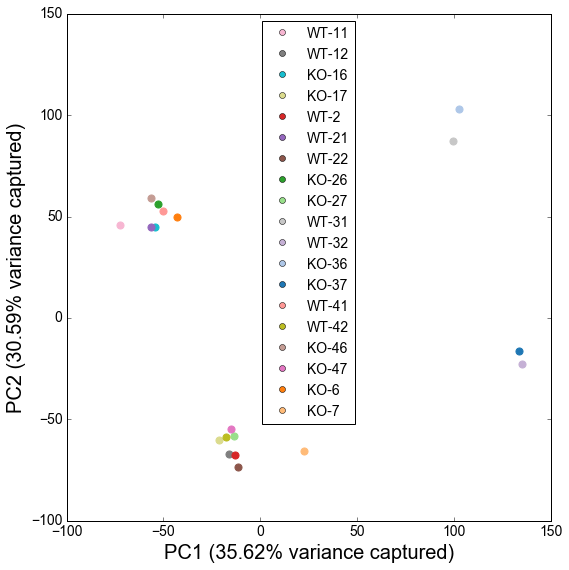

In [202]:
# plot PCA
%matplotlib inline
RNAseq.PCA_plot(expr_df.values, meta_df['Type'], 
         standardize=2, log=True, 
         show_text=False, sep=' ', legend_loc='upper center')

Samples 37, 32, 36, 31 were outliers as seen on the PCA plot and were removed from the analysis.

Alternatively, we can visualize the gene expression matrix using Clustergrammer. Clustergrammer is a visualization tool that we developed to enable users and web-based applications to easily generate interactive and shareable clustergram-heatmap visualizations from a matrices of data. In the following code, we display a subset the expression matrix using genes with the largest variance. We then log transform and z-score center the expression matrix so that it has an average of zero, and a standard deviation of unity for each gene on the rows. We write the subset of expression matrix into a text file, and then use a HTTP POST of this file to the API of Clustergrammer. The API then responds with a URL to the interactive clustergram.

In [226]:
## Load the expression matrix - edgeR output
expr_df = pd.read_csv('repCpmMatrix_featureCounts.csv')
expr_df = expr_df.set_index(expr_df.columns[0])
expr_df.head()
print expr_df.shape

(24391, 19)


In [227]:
expr_df = expr_df.drop(['31-1167-Wt-P8','32-1167-Wt-P9','36-1168-IgAKO-P8','37-1168-IgAKO-P9'], axis=1)

In [228]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
print (expr_df.shape)

## Filter out lowly expressed genes
mask_low_vals = (expr_df > 0.3).sum(axis=1) > 5
expr_df = expr_df.loc[mask_low_vals, :]

print (expr_df.shape)

expr_df.to_csv('expr_df_outliers', sep=',', na_rep='', float_format=None, columns=None, header=True, index=True, 
               index_label=None, mode='w', encoding=None, compression=None, quoting=None, quotechar='"', 
               line_terminator='\n', tupleize_cols=False, date_format=None, doublequote=True, 
               escapechar=None, decimal='.')

(16390, 15)
(11593, 15)


In [229]:
meta_df = pd.read_csv('metadata.txt', sep='\t')
meta_df.shape
meta_df

,Unnamed: 0,Condition,Type,Category
0,11-1163-Wt-P8,WT Marginal B cell,WT-11,WTM
1,12-1163-Wt-P9,WT Follicular B cell,WT-12,WTF
2,16-1164-IgAKO-P8,IgA KO Marginal B cell,KO-16,KoM
3,17-1164-IgAKO-P9,IgA KO Follicular B cell,KO-17,KoF
4,2-1161-Wt-P9,WT Follicular B cell,WT-2,WTF
5,21-1165-Wt-P8,WT Marginal B cell,WT-21,WTM
6,22-1165-Wt-P9,WT Follicular B cell,WT-22,WTF
7,26-1166-IgAKO-P8,IgA KO Marginal B cell,KO-26,KoM
8,27-1166-IgAKO-P9,IgA KO Follicular B cell,KO-27,KoF
9,31-1167-Wt-P8,WT Marginal B cell,WT-31,WTM


In [230]:
# Subset the expression DataFrame using top 800 genes with largest variance
variances = np.var(expr_df, axis=1)
srt_idx = variances.argsort()[::-1]
expr_df_sub = expr_df.iloc[srt_idx].iloc[:800]
print expr_df_sub.shape
expr_df_sub.head()

(800, 15)


,11-1163-Wt-P8,12-1163-Wt-P9,16-1164-IgAKO-P8,17-1164-IgAKO-P9,2-1161-Wt-P9,21-1165-Wt-P8,22-1165-Wt-P9,26-1166-IgAKO-P8,27-1166-IgAKO-P9,41-1169-Wt-P8,42-1169-Wt-P9,46-1170-IgAKO-P8,47-1170-IgAKO-P9,6-1162-IgAKO-P8,7-1162-IgAKO-P9
Unnamed: 0,,,,,,,,,,,,,,,
Rn45s,2413.222760,2666.823511,6571.134161,4631.309254,1753.034020,2922.196686,1941.823000,2632.597367,1948.955895,8006.601673,8070.209369,10437.204774,7045.461548,2440.112137,1780.516106
Cd74,16226.126188,19569.920339,15676.565216,21334.349545,21218.828304,17458.661938,21208.262611,16150.600372,20382.392432,16775.711996,21266.776704,16183.762927,21082.238864,16144.149443,20125.278786
Cr2,3001.219615,882.809944,3296.624540,805.657036,957.730065,3411.434690,867.495750,3682.600140,891.111785,2994.875204,790.300306,2845.872828,673.498296,3381.787441,762.060359
Psap,4121.344680,1880.915785,4120.018484,1838.789846,1790.695894,4359.772645,1838.920056,4252.671146,1784.171801,3933.960310,1636.948863,3916.855311,1489.582004,4194.948162,1729.833815
Eef2,10465.050515,8295.245438,10997.439720,8660.672518,7875.043347,10232.420441,8055.360416,10559.219611,8514.539580,9190.180907,7568.038904,9973.337848,7992.302038,9933.736243,7583.237647


In [231]:
# Log transform and z-score standardize the data and write to a .txt file 
expr_df_sub.index.name=''
expr_df_sub = np.log1p(expr_df_sub)
expr_df_sub = expr_df_sub.apply(lambda x: (x-x.mean())/x.std(ddof=0), axis=1)
# prettify sample names
#sample_names = ['-'.join([x, d_layout_platform[y], z]) for x,y,z in
#                   zip(meta_df['infection_status_s'], meta_df['LibraryLayout_s'], expr_df_sub.columns)]
#expr_df_sub.columns = sample_names
expr_df_sub.to_csv('expression_matrix_top800_genes.txt', sep='\t')
expr_df_sub


,11-1163-Wt-P8,12-1163-Wt-P9,16-1164-IgAKO-P8,17-1164-IgAKO-P9,2-1161-Wt-P9,21-1165-Wt-P8,22-1165-Wt-P9,26-1166-IgAKO-P8,27-1166-IgAKO-P9,41-1169-Wt-P8,42-1169-Wt-P9,46-1170-IgAKO-P8,47-1170-IgAKO-P9,6-1162-IgAKO-P8,7-1162-IgAKO-P9
,,,,,,,,,,,,,,,
Rn45s,-0.646343,-0.483020,0.991149,0.419218,-1.168692,-0.333547,-1.001546,-0.504133,-0.995553,1.314168,1.327105,1.747604,1.105095,-0.628232,-1.143272
Cd74,-1.103725,0.422473,-1.384376,1.125621,1.081396,-0.507381,1.077339,-1.141726,0.753808,-0.832410,1.099781,-1.125018,1.028793,-1.144980,0.650405
Cr2,0.956575,-0.826925,1.093452,-0.960146,-0.708254,1.143366,-0.852418,1.254887,-0.813289,0.953490,-0.988179,0.879086,-1.221107,1.130640,-1.041180
Psap,1.056894,-0.753050,1.056151,-0.805306,-0.866447,1.186678,-0.805142,1.129280,-0.874867,0.949513,-1.073535,0.939457,-1.291149,1.097743,-0.946218
Eef2,1.202606,-0.632791,1.594569,-0.292271,-1.043404,1.025034,-0.864581,1.273367,-0.426688,0.176478,-1.357498,0.822457,-0.926658,0.791029,-1.341651
H2-Aa,-0.921891,0.610283,-0.947842,1.147199,1.447356,-1.066813,0.670884,-1.089171,0.564606,-0.952542,1.140434,-0.566180,1.358301,-1.414654,0.020030
H2-Ab1,-1.186200,-0.022487,-1.596624,0.673086,0.754102,-0.853426,0.660685,-1.063557,0.281397,0.380880,1.622577,0.160825,1.689868,-1.406415,-0.094711
Eef1a1,0.808907,-1.190709,1.171031,-0.425834,-1.022927,0.173293,-1.127956,0.859097,-0.805922,1.093251,-0.415259,1.946904,0.061268,0.397684,-1.522827
Junb,-0.969136,0.156372,-0.514639,1.076369,-0.151079,-0.064825,1.441648,-0.983350,-0.079262,-1.193746,-0.571052,-1.086908,-0.391096,0.993781,2.336923


In [247]:
import requests, json

In [249]:
# POST the expression matrix to Clustergrammer and get the URL
#import requests, json
#clustergrammer_url = 'http://amp.pharm.mssm.edu/clustergrammer/upload_matrix/'

#r = requests.post(clustergrammer_url, files={'file': open('expression_matrix_top800_genes.txt', 'rb')})
#link = r.text

#display_link(link)

# POST the expression matrix to Clustergrammer and get the URL
import requests, json

clustergrammer_url = 'http://amp.pharm.mssm.edu/clustergrammer/matrix_upload/'
files={'file': open('expression_matrix_top800_genes.txt', 'rb')}

r = requests.post(clustergrammer_url, files=files)

link = r.text
link


u'http://amp.pharm.mssm.edu/clustergrammer/viz/57326bc4f4bc77055262ccd9/expression_matrix_top800_genes.txt'

In [251]:
from IPython.display import IFrame
display(IFrame(link, width="1000", height="900"))

Now we are ready to identify the differentially expressed genes between the two sets of samples: control vs. treatment. We will achieve this using the Characteristic Direction method6 that we developed and published in BMC Bioinformatics in 2014.<br>
An implementation in Python of the Characteristic Direction method can be downloaded and installed from here: https://github.com/wangz10/geode.

In [ ]:
import geode
d_platform_cd = {} # to top up/down genes
cd_results = pd.DataFrame(index=expr_df.index)

sample_classes = {}
for layout in meta_df['LibraryLayout_s'].unique():
    ## make sample_class 
    sample_class = np.zeros(expr_df.shape[1], dtype=np.int32)
    sample_class[meta_df['LibraryLayout_s'].values == layout] = 1
    sample_class[(meta_df['LibraryLayout_s'].values == layout) & 
                 (meta_df['infection_status_s'].values == 'Zika infected')] = 2
    platform = d_layout_platform[layout]
    sample_classes[platform] = sample_class

sample_classes['combined'] = sample_classes['MiSeq'] + sample_classes['NextSeq 500']
print sample_classes

for platform, sample_class in sample_classes.items():
    cd_res = geode.chdir(expr_df.values, sample_class, expr_df.index, 
                      gamma=.5, sort=False, calculate_sig=False)
    cd_coefs = np.array(map(lambda x: x[0], cd_res))
    cd_results[platform] = cd_coefs
    
    # sort CD in by absolute values in descending order
    srt_idx = np.abs(cd_coefs).argsort()[::-1]
    cd_coefs = cd_coefs[srt_idx][:600]
    sorted_DEGs = expr_df.index[srt_idx][:600]
    # split up and down
    up_genes = dict(zip(sorted_DEGs[cd_coefs > 0], cd_coefs[cd_coefs > 0]))
    dn_genes = dict(zip(sorted_DEGs[cd_coefs < 0], cd_coefs[cd_coefs < 0]))
    d_platform_cd[platform+'-up'] = up_genes
    d_platform_cd[platform+'-dn'] = dn_genes

print cd_results.head()